# MOwNiT - laboratorium 11
### Faktoryzacja QR

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

## Implementacja dekompozycji QR

In [2]:
def qr(A):
    n = A.shape[0]
    Q = np.empty((n,n))
    R = np.zeros((n,n))
    
    u_k = A[:,0:1] / np.linalg.norm(A[:,0:1], axis=0)
    Q[:,0:1] = u_k
    R[0,0] = u_k.T @ A[:,0:1]
    for k in range(1,n):
        a_k = A[:,k:k+1]
        u_prev = Q[:,:k]
        projections = u_prev.T @ a_k
        R[:k,k:k+1] = projections
        u_k = a_k - np.sum(u_prev * projections.T, axis=1, keepdims=True)
        u_k = u_k / np.linalg.norm(u_k, axis=0)
        
        Q[:,k:k+1] = u_k
        R[k,k] = u_k.T @ a_k
    
    return Q, R

### Testowanie implementacji QR
Porówananie wyników i czasów wykonania z implementacją biblioteczną NumPy

In [94]:
def qr_test(A):
    print("---")
    print(f"Matrix of size {A.shape}")
    
    start_time = time.time()
    my_q, my_r = qr(A)
    end_time = time.time()
    print(f"My implementation time: {end_time - start_time}s")
    
    start_time = time.time()
    q, r = np.linalg.qr(A)
    end_time = time.time()
    print(f"NumPy implementation time: {end_time - start_time}s")
    
    q_relative_err = np.max(np.abs(1 - np.abs(my_q / q)))
    print(f"Max Q relative error = {q_relative_err}")

In [97]:
qr_t1 = np.random.random((50,50))
qr_t2 = np.random.random((100,100))
qr_t3 = np.random.random((500,500))
qr_t4 = np.random.random((1000,1000))
qr_t5 = np.random.random((2000,2000))

test_suite = [qr_t1, qr_t2, qr_t3, qr_t4, qr_t5]

In [98]:
for A in test_suite:
    qr_test(A)

---
Matrix of size (50, 50)
My implementation time: 0.00747990608215332s
NumPy implementation time: 0.0005583763122558594s
Max Q relative error = 2.8315148004054436e-09
---
Matrix of size (100, 100)
My implementation time: 0.0039234161376953125s
NumPy implementation time: 0.0005538463592529297s
Max Q relative error = 2.7048285833330965e-10
---
Matrix of size (500, 500)
My implementation time: 0.09680747985839844s
NumPy implementation time: 0.0056362152099609375s
Max Q relative error = 2.905027751687328e-08
---
Matrix of size (1000, 1000)
My implementation time: 0.8497622013092041s
NumPy implementation time: 0.034430742263793945s
Max Q relative error = 9.74147674748238e-07
---
Matrix of size (2000, 2000)
My implementation time: 7.4512779712677s
NumPy implementation time: 0.1994311809539795s
Max Q relative error = 2.029756251964443e-06


### Losowa macierz kwadratowa z zadanym współczynnikiem uwarunkowania
Powstaje ona z dwóch macierzy ortogonalnych $U$ i $V^T$ uzyskanych dzięki dekompozycji QR losowych macierzy oraz macierzy diagonalnej $S$, na jej przekątnej wartości maleją liniowo od wartości $cond$ do $1$

Macierze te traktujemy jako wynik dekompozycji SVD, więc macierz końcowa jest wyliczana jako $USV^T$

In [74]:
def rand_matrix_with_cond(size, cond):
    u, _ = np.linalg.qr(np.random.random((size, size)))
    v_t, _ = np.linalg.qr(np.random.random((size, size)))
    s = np.linspace(cond, 1, size)
    return u @ np.diag(s) @ v_t

### Wykres 
### $$|| I - Q^TQ ||$$
gdzie Q jest macierzą Q w dekompozycji QR macierzy A
#### w zależności od
### $$cond(A)$$

In [101]:
def check_with_identity(A):
    q, _ = qr(A)
    return np.linalg.cond(A), np.linalg.norm(np.identity(q.shape[0]) - q.T @ q)

In [102]:
id_test_suite = [rand_matrix_with_cond(8, 2**i) for i in range(1,51)]

x_i = []
y_i = []

for A in id_test_suite:
    cond, similarity = check_with_identity(A)
    x_i.append(cond)
    y_i.append(similarity)

<IPython.core.display.Javascript object>


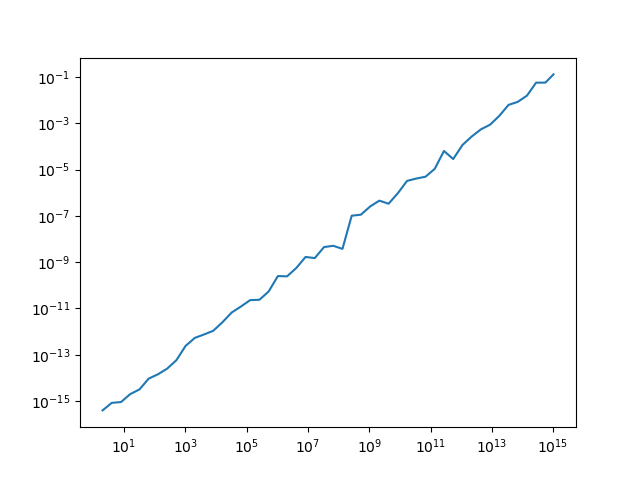

In [103]:
%matplotlib notebook

plt.close()
plt.xscale("log")
plt.yscale("log")
plt.plot(x_i, y_i)
plt.draw()
plt.show()

Wykres pokazuje, że zależność ta jest liniowa. Oznacza to, że czym większy jest współczynnik uwarunkowania macierzy, tym mniej macierz $Q$ przypomina macierz ortogonalną. Jest to spowodowane faktem, iż w każdej kolejnej iteracji algorytmu do policzenia wektora $u_k$ potrzeba odjąć od wektora $a_k$ sumę $\sum_{i=1}^{k-1}<u_i,a_k>u_i$, gdzie wektory $u_i$ zapamiętywane są przy użyciu typu zmiennoprzecinkowego, są więc one narażone na błąd zaokrąglenia, tym większy, im wyższy jest współczynnik uwarunkowania macierzy.

Z tego powodu algorytm Grama-Schmidt'a jest niestabilny numerycznie; każdy kolejny wektor $u_k$ jest narażony na coraz większy błąd i w konsekwencji macierz $Q$ traci własności macierzy ortogonalnej.

## Rozwiązywanie nadokreślonych układów równań metodą QR
Funkcja qr_solve rozwiązuje układ równań postaci Ax = b, przyjmuje jako parametry:
- A: np.ndarray
- b: np.ndarray (wektor pionowy)

Zwraca:
- _: np.ndarray (wektor z rozwiązaniem układu)

In [68]:
def qr_solve(A, b):
    q, r = np.linalg.qr(A)
    return np.linalg.solve(r, q.T @ b)

In [69]:
def lsq_quadratic_solver(xs, ys):
    A = np.vstack([xs**2, xs**1, xs**0]).T
    b = np.vstack([ys]).T
    return qr_solve(A, b)

In [70]:
def plot_quadratic_eq(a, b, c, min_x=-8, max_x=8, sampling_ratio=50):
    xs = np.linspace(min_x, max_x, np.ceil(sampling_ratio * (max_x - min_x)))
    ys = []
    for x_sample in xs:
        ys.append(a*x_sample**2 + b*x_sample + c)
    plt.close()
    plt.plot(xs, ys)
    plt.plot(x, y, "rx")
    plt.draw()

<IPython.core.display.Javascript object>


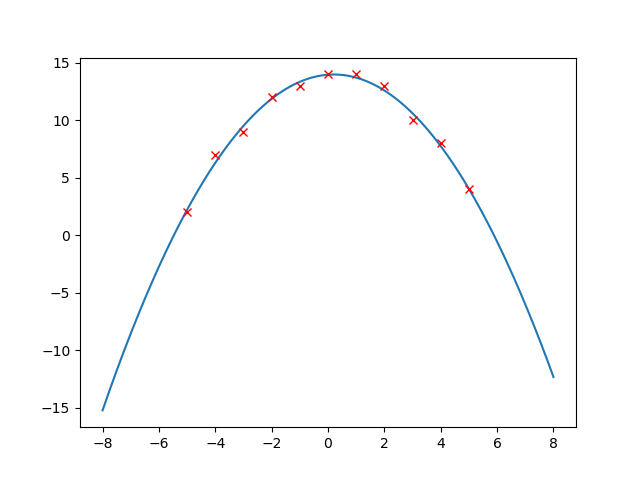

In [71]:
x = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])
y = np.array([2,7,9,12,13,14,14,13,10,8,4])    

a, b, c = lsq_quadratic_solver(x, y)
plot_quadratic_eq(a,b,c)